In [ ]:
# Install required libraries and set up the environment in Colab
!pip install torch torchvision torchaudio
!pip install wandb
!pip install pillow
!pip install opencv-python

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import json
import os
from PIL import Image
import numpy as np
import wandb
import cv2
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
# Upload dataset.zip and unzip it in Colab
from google.colab import files
uploaded = files.upload()  # Upload dataset.zip when prompted

!unzip dataset.zip -d /content/dataset

Saving dataset.zip to dataset.zip
Archive:  dataset.zip
   creating: /content/dataset/dataset/
  inflating: /content/dataset/dataset/.DS_Store  
  inflating: /content/dataset/__MACOSX/dataset/._.DS_Store  
   creating: /content/dataset/dataset/training/
   creating: /content/dataset/dataset/validation/
  inflating: /content/dataset/dataset/training/data.json  
   creating: /content/dataset/dataset/training/outputs/
   creating: /content/dataset/dataset/training/inputs/
  inflating: /content/dataset/dataset/validation/data.json  
   creating: /content/dataset/dataset/validation/outputs/
   creating: /content/dataset/dataset/validation/inputs/
  inflating: /content/dataset/dataset/training/outputs/green_octagon.png  
  inflating: /content/dataset/dataset/training/outputs/blue_hexagon.png  
  inflating: /content/dataset/dataset/training/outputs/green_diamond.png  
  inflating: /content/dataset/dataset/training/outputs/cyan_triangle.png  
  inflating: /content/dataset/dataset/training/outp

In [ ]:
# Define a mapping from color names to RGB values
color_map = {
    'cyan': (0, 255, 255),
    'purple': (128, 0, 128),
    'magenta': (255, 0, 255),
    'green': (0, 255, 0),
    'red': (255, 0, 0),
    'yellow': (255, 255, 0),
    'blue': (0, 0, 255),
    'orange': (255, 165, 0)
}

In [ ]:
# Define a custom dataset class for loading polygon images and colors
class PolygonDataset(Dataset):
    def __init__(self, json_path, input_dir, output_dir, transform=None):
        with open(json_path, 'r') as f:
            self.data = json.load(f)
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_img_path = os.path.join(self.input_dir, item['input_polygon'])
        output_img_path = os.path.join(self.output_dir, item['output_image'])
        color_name = item['colour']

        # Load images
        input_img = Image.open(input_img_path).convert('L')  # Grayscale
        output_img = Image.open(output_img_path).convert('RGB')

        if self.transform:
            input_img = self.transform(input_img)
            output_img = self.transform(output_img)

        # Convert color name to one-hot or embedding
        color_rgb = torch.tensor(color_map[color_name], dtype=torch.float32) / 255.0

        return input_img, color_rgb, output_img

In [ ]:
# Implement a conditional UNet model from scratch
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling path
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottom
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Upsampling path
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Final conv
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        # Color conditioning
        self.color_fc = nn.Linear(3, features[0])  # Color RGB to feature dim

    def forward(self, x, color):
        skip_connections = []

        # Incorporate color at the start
        color_feature = self.color_fc(color).view(-1, 64, 1, 1)
        color_feature = color_feature.expand(-1, 64, x.size(2), x.size(3))
        x = x + color_feature  # Add color info to input

        # Down
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        # Up
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](x)

        return self.final_conv(x)

In [ ]:
# Set up data transforms and data loaders
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = PolygonDataset(
    json_path='/content/dataset/dataset/training/data.json',
    input_dir='/content/dataset/dataset/training/inputs',
    output_dir='/content/dataset/dataset/training/outputs',
    transform=transform
)

val_dataset = PolygonDataset(
    json_path='/content/dataset/dataset/validation/data.json',
    input_dir='/content/dataset/dataset/validation/inputs',
    output_dir='/content/dataset/dataset/validation/outputs',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [9]:
# Train the UNet model with corrected architecture and log metrics to wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import wandb

# Define DoubleConv block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# Define updated UNet model
class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, features=[64, 128, 256, 512]):  # Changed in_channels to 4
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling path
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottom
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Upsampling path
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Final conv
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x, color):
        skip_connections = []

        # Expand color to match image dimensions and concatenate
        color_feature = color.view(-1, 3, 1, 1).expand(-1, 3, x.size(2), x.size(3))
        x = torch.cat((x, color_feature), dim=1)  # Concatenate along channel dimension

        # Down
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        # Up
        skip_connections = skip_connections[::-1]
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](x)

        return self.final_conv(x)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

# Initialize wandb
wandb.init(project="ayna-ml-assignment", config={
    "learning_rate": 0.001,
    "epochs": num_epochs,
    "batch_size": 8,
    "architecture": "UNet"
})

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (input_img, color_rgb, target_img) in enumerate(train_loader):
        input_img, color_rgb, target_img = input_img.to(device), color_rgb.to(device), target_img.to(device)

        optimizer.zero_grad()
        output = model(input_img, color_rgb)
        loss = criterion(output, target_img)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for input_img, color_rgb, target_img in val_loader:
            input_img, color_rgb, target_img = input_img.to(device), color_rgb.to(device), target_img.to(device)
            output = model(input_img, color_rgb)
            loss = criterion(output, target_img)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # Log to wandb
    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Save the model
torch.save(model.state_dict(), 'unet_model.pth')
wandb.finish()

Epoch 1, Train Loss: 0.9326, Val Loss: 3.0105
Epoch 2, Train Loss: 0.4674, Val Loss: 448.4765
Epoch 3, Train Loss: 0.2727, Val Loss: 411.9209
Epoch 4, Train Loss: 0.1944, Val Loss: 2.3225
Epoch 5, Train Loss: 0.1432, Val Loss: 1.4072
Epoch 6, Train Loss: 0.0983, Val Loss: 0.5513
Epoch 7, Train Loss: 0.0870, Val Loss: 0.1609
Epoch 8, Train Loss: 0.0644, Val Loss: 0.2273
Epoch 9, Train Loss: 0.0699, Val Loss: 0.6560
Epoch 10, Train Loss: 0.0503, Val Loss: 0.3502
Epoch 11, Train Loss: 0.0485, Val Loss: 0.2190
Epoch 12, Train Loss: 0.0495, Val Loss: 0.0442
Epoch 13, Train Loss: 0.0564, Val Loss: 1.0723
Epoch 14, Train Loss: 0.0537, Val Loss: 1.0872
Epoch 15, Train Loss: 0.0422, Val Loss: 0.5168
Epoch 16, Train Loss: 0.0394, Val Loss: 0.1982
Epoch 17, Train Loss: 0.0418, Val Loss: 0.0680
Epoch 18, Train Loss: 0.0400, Val Loss: 0.0845
Epoch 19, Train Loss: 0.0352, Val Loss: 0.0757
Epoch 20, Train Loss: 0.0322, Val Loss: 0.0654
Epoch 21, Train Loss: 0.0319, Val Loss: 0.2431
Epoch 22, Train Lo

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
train_loss,0.02316
val_loss,0.02179


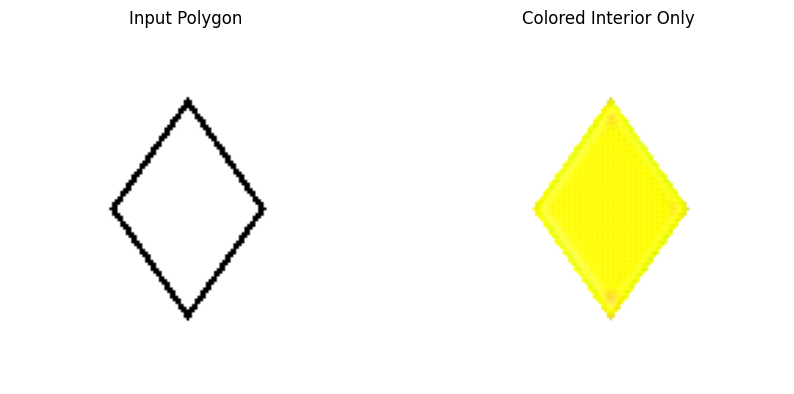

In [35]:
# This cell: Ensures polygon interior is colored by filling the contour detected from black outlines.
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Reload/prepare the custom image as grayscale array
custom_img_path = list(uploaded.keys())[0]
img_pil = Image.open(custom_img_path).convert('L').resize((128,128))
img_np = np.array(img_pil)

# --- Find contours and create filled mask ---
# Invert image: black outlines become white; inside stays black
_, mask_bin = cv2.threshold(255 - img_np, 10, 255, cv2.THRESH_BINARY)

# Find contours of the polygon
contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_filled = np.zeros_like(mask_bin)
cv2.drawContours(mask_filled, contours, -1, color=255, thickness=cv2.FILLED)

# Convert filled mask to float [0,1] for overlay
mask_filled = mask_filled.astype(np.float32) / 255.0
mask_filled = np.expand_dims(mask_filled, axis=0)  # Shape (1,H,W)

# Model inference as before
with torch.no_grad():
    output_img = model(transform(img_pil).unsqueeze(0).to(device), color_rgb)
output_img = torch.clamp(output_img, 0, 1).squeeze().cpu().numpy()

# Compose final image: output color only inside the filled mask, else white
output_final = output_img * mask_filled + (1 - mask_filled) * 1.0

# Show results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title('Input Polygon'); plt.imshow(img_np, cmap='gray'); plt.axis('off')
plt.subplot(1,2,2); plt.title('Colored Interior Only'); plt.imshow(np.transpose(output_final, (1,2,0))); plt.axis('off')
plt.show()


Saving octagon.png to octagon (1).png
Available colors: ['cyan', 'purple', 'magenta', 'green', 'red', 'yellow', 'blue', 'orange']
Enter desired color: purple


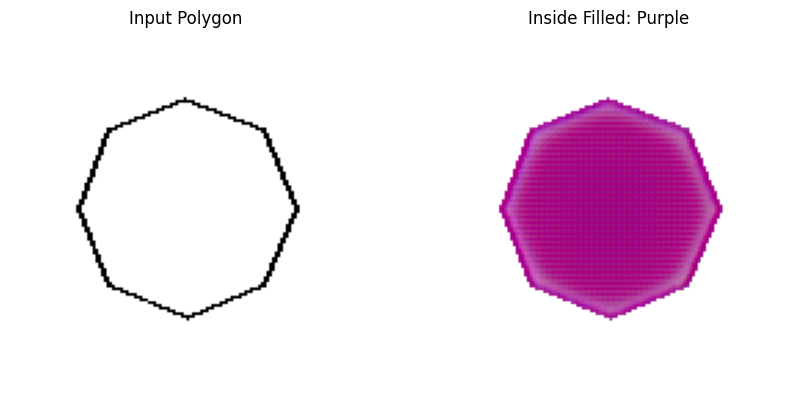

In [38]:
# This cell: User can upload a polygon image and PICK any color; only the interior will be colored.

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# Color map (expand if needed)
color_map = {
    'cyan': (0, 255, 255),
    'purple': (128, 0, 128),
    'magenta': (255, 0, 255),
    'green': (0, 255, 0),
    'red': (255, 0, 0),
    'yellow': (255, 255, 0),
    'blue': (0, 0, 255),
    'orange': (255, 165, 0)
}

# (Re)load trained model if needed (run this block after training, with the model and color_map defined)
# UNet class/model/transform assumed already defined as before

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

# ----- User: Upload image interactively -----
from google.colab import files
uploaded = files.upload()  # Prompt: upload a polygon outline image (.png or .jpg)

# AUTO-DETECT uploaded filename
custom_img_path = list(uploaded.keys())[0]
img_pil = Image.open(custom_img_path).convert('L').resize((128,128))
img_np = np.array(img_pil)

# ----- User: Choose color -----
print('Available colors:', list(color_map.keys()))
color_name = input('Enter desired color: ').strip().lower()
if color_name not in color_map:
    raise ValueError(f"Invalid color! Must be one of {list(color_map.keys())}")
color_rgb = torch.tensor(color_map[color_name], dtype=torch.float32).unsqueeze(0).to(device) / 255.0

# --- Find contours and create filled mask ---
_, mask_bin = cv2.threshold(255 - img_np, 10, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_filled = np.zeros_like(mask_bin)
cv2.drawContours(mask_filled, contours, -1, color=255, thickness=cv2.FILLED)
mask_filled = mask_filled.astype(np.float32) / 255.0
mask_filled = np.expand_dims(mask_filled, axis=0)  # (1, H, W)

# Model inference (always use transform from training)
transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])
with torch.no_grad():
    img_tensor = transform(img_pil).unsqueeze(0).to(device)
    output_img = model(img_tensor, color_rgb)
output_img = torch.clamp(output_img, 0, 1).squeeze().cpu().numpy()

# Compose final image: output color inside mask, else white
output_final = output_img * mask_filled + (1 - mask_filled) * 1.0

# Visualize
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title('Input Polygon'); plt.imshow(img_np, cmap='gray'); plt.axis('off')
plt.subplot(1,2,2); plt.title(f'Inside Filled: {color_name.title()}'); plt.imshow(np.transpose(output_final, (1,2,0))); plt.axis('off')
plt.show()


Saving square.png to square.png
Available colors: ['cyan', 'purple', 'magenta', 'green', 'red', 'yellow', 'blue', 'orange']
Enter desired color: green


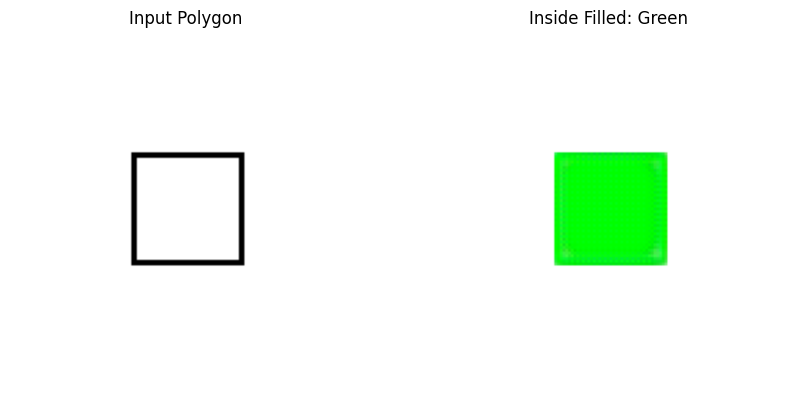

In [39]:
# This cell: User can upload a polygon image and PICK any color; only the interior will be colored.

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# Color map (expand if needed)
color_map = {
    'cyan': (0, 255, 255),
    'purple': (128, 0, 128),
    'magenta': (255, 0, 255),
    'green': (0, 255, 0),
    'red': (255, 0, 0),
    'yellow': (255, 255, 0),
    'blue': (0, 0, 255),
    'orange': (255, 165, 0)
}

# (Re)load trained model if needed (run this block after training, with the model and color_map defined)
# UNet class/model/transform assumed already defined as before

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

# ----- User: Upload image interactively -----
from google.colab import files
uploaded = files.upload()  # Prompt: upload a polygon outline image (.png or .jpg)

# AUTO-DETECT uploaded filename
custom_img_path = list(uploaded.keys())[0]
img_pil = Image.open(custom_img_path).convert('L').resize((128,128))
img_np = np.array(img_pil)

# ----- User: Choose color -----
print('Available colors:', list(color_map.keys()))
color_name = input('Enter desired color: ').strip().lower()
if color_name not in color_map:
    raise ValueError(f"Invalid color! Must be one of {list(color_map.keys())}")
color_rgb = torch.tensor(color_map[color_name], dtype=torch.float32).unsqueeze(0).to(device) / 255.0

# --- Find contours and create filled mask ---
_, mask_bin = cv2.threshold(255 - img_np, 10, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_filled = np.zeros_like(mask_bin)
cv2.drawContours(mask_filled, contours, -1, color=255, thickness=cv2.FILLED)
mask_filled = mask_filled.astype(np.float32) / 255.0
mask_filled = np.expand_dims(mask_filled, axis=0)  # (1, H, W)

# Model inference (always use transform from training)
transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])
with torch.no_grad():
    img_tensor = transform(img_pil).unsqueeze(0).to(device)
    output_img = model(img_tensor, color_rgb)
output_img = torch.clamp(output_img, 0, 1).squeeze().cpu().numpy()

# Compose final image: output color inside mask, else white
output_final = output_img * mask_filled + (1 - mask_filled) * 1.0

# Visualize
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title('Input Polygon'); plt.imshow(img_np, cmap='gray'); plt.axis('off')
plt.subplot(1,2,2); plt.title(f'Inside Filled: {color_name.title()}'); plt.imshow(np.transpose(output_final, (1,2,0))); plt.axis('off')
plt.show()


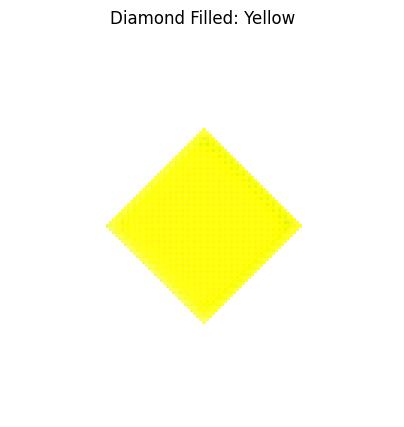

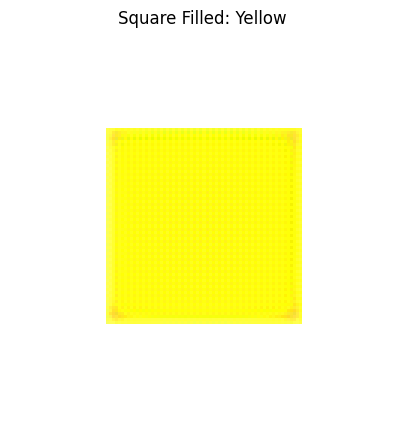

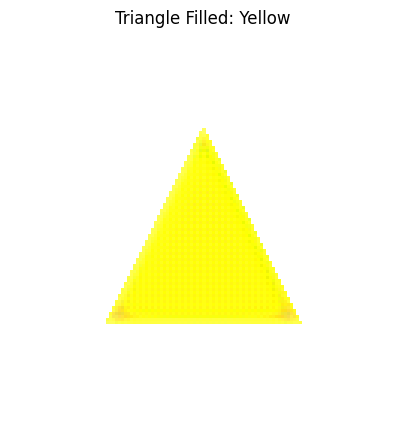

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# Color map
color_map = {
    'cyan': (0, 255, 255),
    'purple': (128, 0, 128),
    'magenta': (255, 0, 255),
    'green': (0, 255, 0),
    'red': (255, 0, 0),
    'yellow': (255, 255, 0),
    'blue': (0, 0, 255),
    'orange': (255, 165, 0)
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

# Predefined polygons (as binary masks)
polygons = {
    'diamond': np.zeros((128, 128), dtype=np.uint8),
    'square': np.zeros((128, 128), dtype=np.uint8),
    'triangle': np.zeros((128, 128), dtype=np.uint8)
}

# Define diamond (rotated square)
pts_diamond = np.array([[[64, 32], [96, 64], [64, 96], [32, 64]]], dtype=np.int32)
cv2.fillPoly(polygons['diamond'], pts_diamond, 255)

# Define square
pts_square = np.array([[[32, 32], [96, 32], [96, 96], [32, 96]]], dtype=np.int32)
cv2.fillPoly(polygons['square'], pts_square, 255)

# Define triangle
pts_triangle = np.array([[[32, 96], [64, 32], [96, 96]]], dtype=np.int32)
cv2.fillPoly(polygons['triangle'], pts_triangle, 255)

# Fixed color
color_name = 'yellow'
color_rgb = torch.tensor(color_map[color_name], dtype=torch.float32).unsqueeze(0).to(device) / 255.0

# Process each polygon
for poly_name, poly_img in polygons.items():
    img_tensor = transforms.ToTensor()(poly_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output_img = model(img_tensor, color_rgb)
    output_img = torch.clamp(output_img, 0, 1).squeeze().cpu().numpy()
    mask_filled = poly_img.astype(np.float32) / 255.0
    mask_filled = np.expand_dims(mask_filled, axis=0)
    output_final = output_img * mask_filled + (1 - mask_filled) * 1.0

    plt.figure(figsize=(5, 5))
    plt.title(f'{poly_name.title()} Filled: {color_name.title()}')
    plt.imshow(np.transpose(output_final, (1, 2, 0)))
    plt.axis('off')
    plt.show()

Saving hexagon.png to hexagon.png
Available colors: ['cyan', 'purple', 'magenta', 'green', 'red', 'yellow', 'blue', 'orange']
Enter desired color: purple


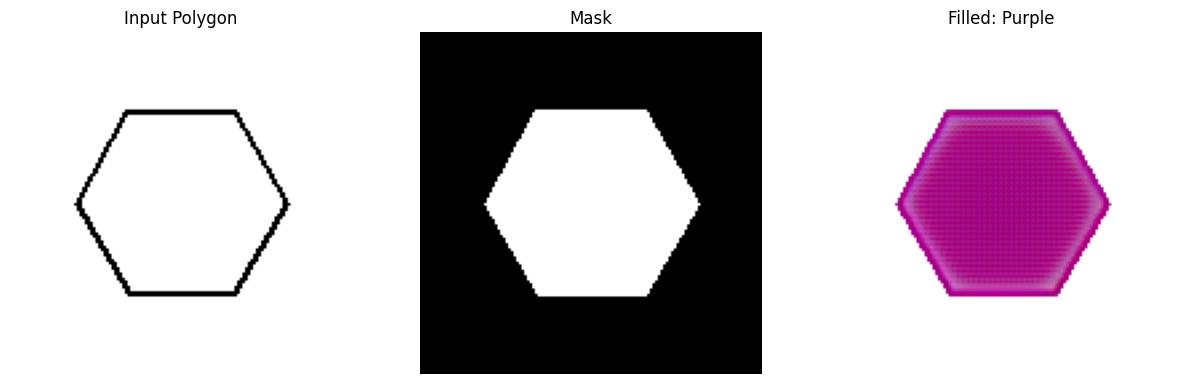

In [41]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# Color map
color_map = {
    'cyan': (0, 255, 255),
    'purple': (128, 0, 128),
    'magenta': (255, 0, 255),
    'green': (0, 255, 0),
    'red': (255, 0, 0),
    'yellow': (255, 255, 0),
    'blue': (0, 0, 255),
    'orange': (255, 165, 0)
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

# Upload image
from google.colab import files
uploaded = files.upload()  # Prompt: upload a polygon outline image (.png or .jpg)
custom_img_path = list(uploaded.keys())[0]
img_pil = Image.open(custom_img_path).convert('L').resize((128, 128))
img_np = np.array(img_pil)

# Choose color
print('Available colors:', list(color_map.keys()))
color_name = input('Enter desired color: ').strip().lower()
if color_name not in color_map:
    raise ValueError(f"Invalid color! Must be one of {list(color_map.keys())}")
color_rgb = torch.tensor(color_map[color_name], dtype=torch.float32).unsqueeze(0).to(device) / 255.0

# Create filled mask
_, mask_bin = cv2.threshold(255 - img_np, 10, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_filled = np.zeros_like(mask_bin)
cv2.drawContours(mask_filled, contours, -1, color=255, thickness=cv2.FILLED)
mask_filled = mask_filled.astype(np.float32) / 255.0
mask_filled = np.expand_dims(mask_filled, axis=0)

# Model inference
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
with torch.no_grad():
    img_tensor = transform(img_pil).unsqueeze(0).to(device)
    output_img = model(img_tensor, color_rgb)
output_img = torch.clamp(output_img, 0, 1).squeeze().cpu().numpy()

# Compose final image
output_final = output_img * mask_filled + (1 - mask_filled) * 1.0

# Visualize: Input, Mask, and Colored Output
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title('Input Polygon'); plt.imshow(img_np, cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title('Mask'); plt.imshow(mask_filled[0], cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title(f'Filled: {color_name.title()}'); plt.imshow(np.transpose(output_final, (1, 2, 0))); plt.axis('off')
plt.show()

Available polygons: ['diamond', 'square', 'triangle']
Enter desired polygon (diamond, square, triangle): square
Available colors: ['cyan', 'purple', 'magenta', 'green', 'red', 'yellow', 'blue', 'orange']
Enter desired color: magenta


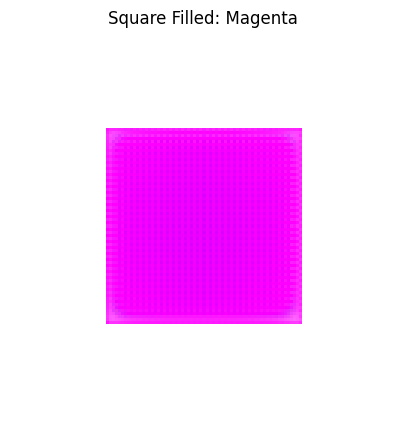

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# Color map
color_map = {
    'cyan': (0, 255, 255),
    'purple': (128, 0, 128),
    'magenta': (255, 0, 255),
    'green': (0, 255, 0),
    'red': (255, 0, 0),
    'yellow': (255, 255, 0),
    'blue': (0, 0, 255),
    'orange': (255, 165, 0)
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

# Predefined polygons
polygons = {
    'diamond': np.zeros((128, 128), dtype=np.uint8),
    'square': np.zeros((128, 128), dtype=np.uint8),
    'triangle': np.zeros((128, 128), dtype=np.uint8)
}

# Define shapes
pts_diamond = np.array([[[64, 32], [96, 64], [64, 96], [32, 64]]], dtype=np.int32)
cv2.fillPoly(polygons['diamond'], pts_diamond, 255)

pts_square = np.array([[[32, 32], [96, 32], [96, 96], [32, 96]]], dtype=np.int32)
cv2.fillPoly(polygons['square'], pts_square, 255)

pts_triangle = np.array([[[32, 96], [64, 32], [96, 96]]], dtype=np.int32)
cv2.fillPoly(polygons['triangle'], pts_triangle, 255)

# Choose polygon
print('Available polygons:', list(polygons.keys()))
poly_name = input('Enter desired polygon (diamond, square, triangle): ').strip().lower()
if poly_name not in polygons:
    raise ValueError(f"Invalid polygon! Must be one of {list(polygons.keys())}")
poly_img = polygons[poly_name]

# Choose color
print('Available colors:', list(color_map.keys()))
color_name = input('Enter desired color: ').strip().lower()
if color_name not in color_map:
    raise ValueError(f"Invalid color! Must be one of {list(color_map.keys())}")
color_rgb = torch.tensor(color_map[color_name], dtype=torch.float32).unsqueeze(0).to(device) / 255.0

# Model inference
img_tensor = transforms.ToTensor()(poly_img).unsqueeze(0).to(device)
with torch.no_grad():
    output_img = model(img_tensor, color_rgb)
output_img = torch.clamp(output_img, 0, 1).squeeze().cpu().numpy()
mask_filled = poly_img.astype(np.float32) / 255.0
mask_filled = np.expand_dims(mask_filled, axis=0)
output_final = output_img * mask_filled + (1 - mask_filled) * 1.0

# Visualize
plt.figure(figsize=(5, 5))
plt.title(f'{poly_name.title()} Filled: {color_name.title()}')
plt.imshow(np.transpose(output_final, (1, 2, 0)))
plt.axis('off')
plt.show()

Saving octagon.png to octagon (2).png
Available colors: ['cyan', 'purple', 'magenta', 'green', 'red', 'yellow', 'blue', 'orange']
Enter desired color: red


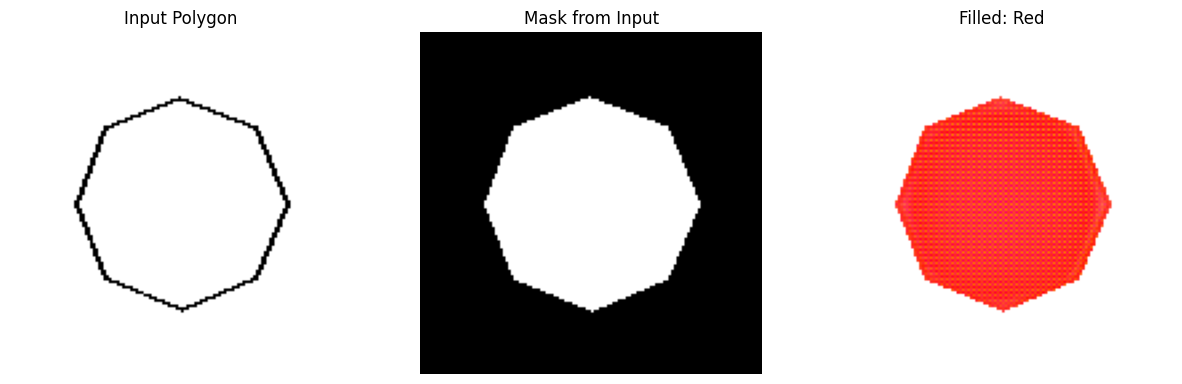

In [43]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# Color map
color_map = {
    'cyan': (0, 255, 255),
    'purple': (128, 0, 128),
    'magenta': (255, 0, 255),
    'green': (0, 255, 0),
    'red': (255, 0, 0),
    'yellow': (255, 255, 0),
    'blue': (0, 0, 255),
    'orange': (255, 165, 0)
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

# Upload image
from google.colab import files
uploaded = files.upload()  # Prompt: upload a polygon outline image (.png or .jpg)
custom_img_path = list(uploaded.keys())[0]
img_pil = Image.open(custom_img_path).convert('L').resize((128, 128))
img_np = np.array(img_pil)

# Choose color
print('Available colors:', list(color_map.keys()))
color_name = input('Enter desired color: ').strip().lower()
if color_name not in color_map:
    raise ValueError(f"Invalid color! Must be one of {list(color_map.keys())}")
color_rgb = torch.tensor(color_map[color_name], dtype=torch.float32).unsqueeze(0).to(device) / 255.0

# Create filled mask from uploaded image
_, mask_bin = cv2.threshold(255 - img_np, 10, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_filled = np.zeros_like(mask_bin)
cv2.drawContours(mask_filled, contours, -1, color=255, thickness=cv2.FILLED)
mask_filled = mask_filled.astype(np.float32) / 255.0
mask_filled = np.expand_dims(mask_filled, axis=0)

# Model inference
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
with torch.no_grad():
    img_tensor = transform(img_pil).unsqueeze(0).to(device)
    output_img = model(img_tensor, color_rgb)
output_img = torch.clamp(output_img, 0, 1).squeeze().cpu().numpy()

# Compose final image
output_final = output_img * mask_filled + (1 - mask_filled) * 1.0

# Visualize: Input, Mask, and Colored Output
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title('Input Polygon'); plt.imshow(img_np, cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title('Mask from Input'); plt.imshow(mask_filled[0], cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title(f'Filled: {color_name.title()}'); plt.imshow(np.transpose(output_final, (1, 2, 0))); plt.axis('off')
plt.show()

Saving pentagon.png to pentagon.png
Upload ground truth image (optional, pre-colored polygon, .png or .jpg) or press Enter to skip.


Saving blue_pentagon.png to blue_pentagon.png
Available colors: ['cyan', 'purple', 'magenta', 'green', 'red', 'yellow', 'blue', 'orange']
Enter desired color: blue


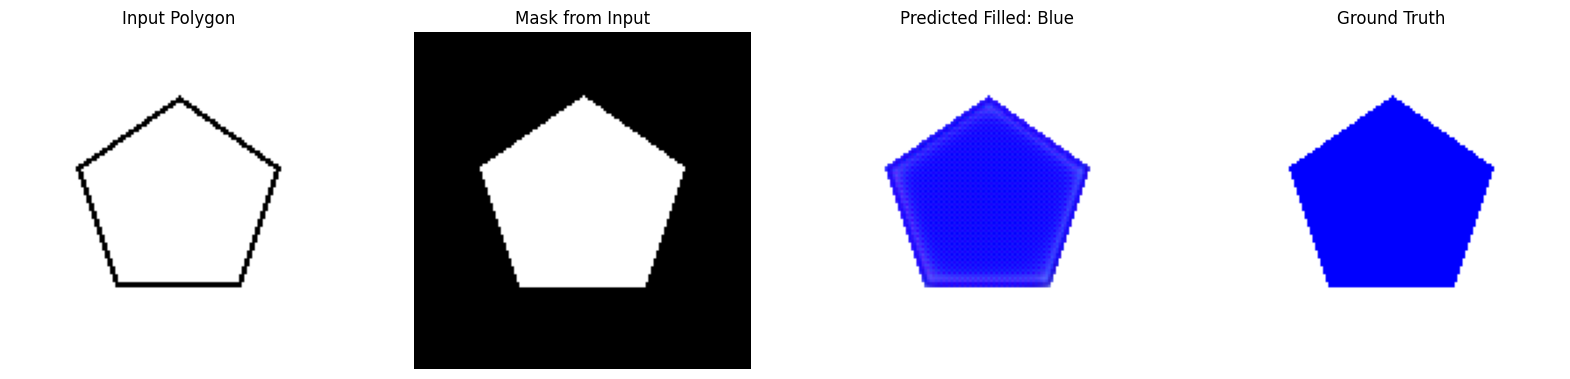

In [46]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# Color map
color_map = {
    'cyan': (0, 255, 255),
    'purple': (128, 0, 128),
    'magenta': (255, 0, 255),
    'green': (0, 255, 0),
    'red': (255, 0, 0),
    'yellow': (255, 255, 0),
    'blue': (0, 0, 255),
    'orange': (255, 165, 0)
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

# Upload input image
from google.colab import files
uploaded = files.upload()  # Prompt: upload a polygon outline image (.png or .jpg)
custom_img_path = list(uploaded.keys())[0]
img_pil = Image.open(custom_img_path).convert('L').resize((128, 128))
img_np = np.array(img_pil)

# Optional: Upload ground truth image
print("Upload ground truth image (optional, pre-colored polygon, .png or .jpg) or press Enter to skip.")
gt_uploaded = files.upload()
gt_img_path = list(gt_uploaded.keys())[0] if gt_uploaded else None
if gt_img_path:
    gt_img_pil = Image.open(gt_img_path).resize((128, 128))
    gt_img_np = np.array(gt_img_pil) / 255.0  # Normalize to [0, 1]
else:
    gt_img_np = None

# Choose color
print('Available colors:', list(color_map.keys()))
color_name = input('Enter desired color: ').strip().lower()
if color_name not in color_map:
    raise ValueError(f"Invalid color! Must be one of {list(color_map.keys())}")
color_rgb = torch.tensor(color_map[color_name], dtype=torch.float32).unsqueeze(0).to(device) / 255.0

# Create filled mask from uploaded image
_, mask_bin = cv2.threshold(255 - img_np, 10, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_filled = np.zeros_like(mask_bin)
cv2.drawContours(mask_filled, contours, -1, color=255, thickness=cv2.FILLED)
mask_filled = mask_filled.astype(np.float32) / 255.0
mask_filled = np.expand_dims(mask_filled, axis=0)

# Model inference
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
with torch.no_grad():
    img_tensor = transform(img_pil).unsqueeze(0).to(device)
    output_img = model(img_tensor, color_rgb)
output_img = torch.clamp(output_img, 0, 1).squeeze().cpu().numpy()

# Compose final image
output_final = output_img * mask_filled + (1 - mask_filled) * 1.0

# Visualize
if gt_img_np is not None:
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1); plt.title('Input Polygon'); plt.imshow(img_np, cmap='gray'); plt.axis('off')
    plt.subplot(1, 4, 2); plt.title('Mask from Input'); plt.imshow(mask_filled[0], cmap='gray'); plt.axis('off')
    plt.subplot(1, 4, 3); plt.title(f'Predicted Filled: {color_name.title()}'); plt.imshow(np.transpose(output_final, (1, 2, 0))); plt.axis('off')
    plt.subplot(1, 4, 4); plt.title('Ground Truth'); plt.imshow(gt_img_np); plt.axis('off')
else:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1); plt.title('Input Polygon'); plt.imshow(img_np, cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title('Mask from Input'); plt.imshow(mask_filled[0], cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title(f'Filled: {color_name.title()}'); plt.imshow(np.transpose(output_final, (1, 2, 0))); plt.axis('off')
plt.show()

Saving star.png to star (1).png
Upload ground truth image (optional, pre-colored polygon, .png or .jpg) or press Enter to skip.


Saving purple_star.png to purple_star.png
Available colors: ['cyan', 'purple', 'magenta', 'green', 'red', 'yellow', 'blue', 'orange']
Enter desired color: purple


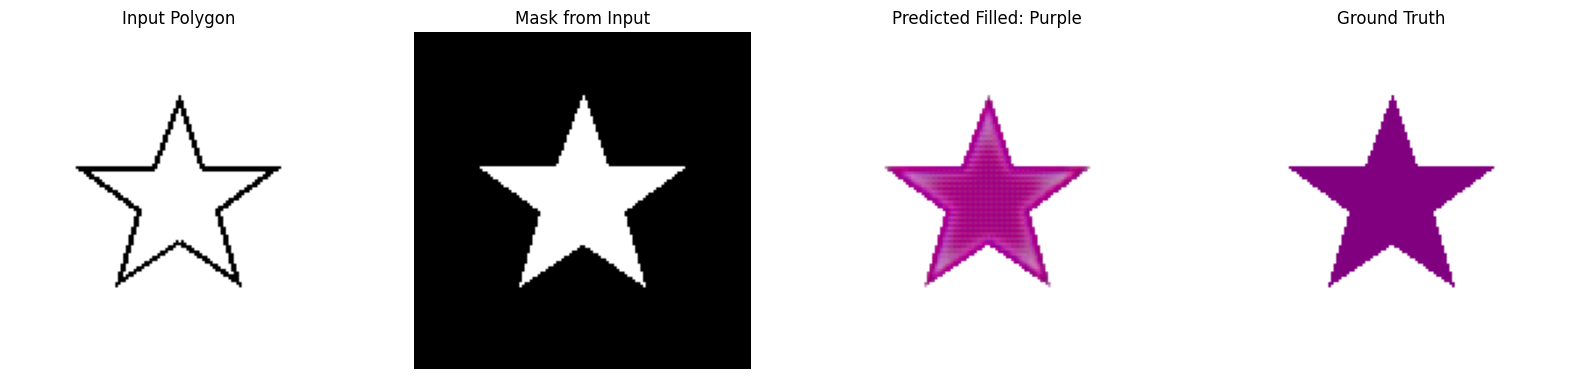

In [48]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# Color map
color_map = {
    'cyan': (0, 255, 255),
    'purple': (128, 0, 128),
    'magenta': (255, 0, 255),
    'green': (0, 255, 0),
    'red': (255, 0, 0),
    'yellow': (255, 255, 0),
    'blue': (0, 0, 255),
    'orange': (255, 165, 0)
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

# Upload input image
from google.colab import files
uploaded = files.upload()  # Prompt: upload a polygon outline image (.png or .jpg)
custom_img_path = list(uploaded.keys())[0]
img_pil = Image.open(custom_img_path).convert('L').resize((128, 128))
img_np = np.array(img_pil)

# Optional: Upload ground truth image
print("Upload ground truth image (optional, pre-colored polygon, .png or .jpg) or press Enter to skip.")
gt_uploaded = files.upload()
gt_img_path = list(gt_uploaded.keys())[0] if gt_uploaded else None
if gt_img_path:
    gt_img_pil = Image.open(gt_img_path).resize((128, 128))
    gt_img_np = np.array(gt_img_pil) / 255.0  # Normalize to [0, 1]
else:
    gt_img_np = None

# Choose color
print('Available colors:', list(color_map.keys()))
color_name = input('Enter desired color: ').strip().lower()
if color_name not in color_map:
    raise ValueError(f"Invalid color! Must be one of {list(color_map.keys())}")
color_rgb = torch.tensor(color_map[color_name], dtype=torch.float32).unsqueeze(0).to(device) / 255.0

# Create filled mask from uploaded image
_, mask_bin = cv2.threshold(255 - img_np, 10, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_filled = np.zeros_like(mask_bin)
cv2.drawContours(mask_filled, contours, -1, color=255, thickness=cv2.FILLED)
mask_filled = mask_filled.astype(np.float32) / 255.0
mask_filled = np.expand_dims(mask_filled, axis=0)

# Model inference
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
with torch.no_grad():
    img_tensor = transform(img_pil).unsqueeze(0).to(device)
    output_img = model(img_tensor, color_rgb)
output_img = torch.clamp(output_img, 0, 1).squeeze().cpu().numpy()

# Compose final image
output_final = output_img * mask_filled + (1 - mask_filled) * 1.0

# Visualize
if gt_img_np is not None:
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1); plt.title('Input Polygon'); plt.imshow(img_np, cmap='gray'); plt.axis('off')
    plt.subplot(1, 4, 2); plt.title('Mask from Input'); plt.imshow(mask_filled[0], cmap='gray'); plt.axis('off')
    plt.subplot(1, 4, 3); plt.title(f'Predicted Filled: {color_name.title()}'); plt.imshow(np.transpose(output_final, (1, 2, 0))); plt.axis('off')
    plt.subplot(1, 4, 4); plt.title('Ground Truth'); plt.imshow(gt_img_np); plt.axis('off')
else:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1); plt.title('Input Polygon'); plt.imshow(img_np, cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title('Mask from Input'); plt.imshow(mask_filled[0], cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title(f'Filled: {color_name.title()}'); plt.imshow(np.transpose(output_final, (1, 2, 0))); plt.axis('off')
plt.show()

Saving circle.png to circle (1).png
Upload ground truth image (optional, pre-colored polygon, .png or .jpg) or press Enter to skip.


Saving cyan_circle.png to cyan_circle.png
Available colors: ['cyan', 'purple', 'magenta', 'green', 'red', 'yellow', 'blue', 'orange']
Enter desired color: cyan


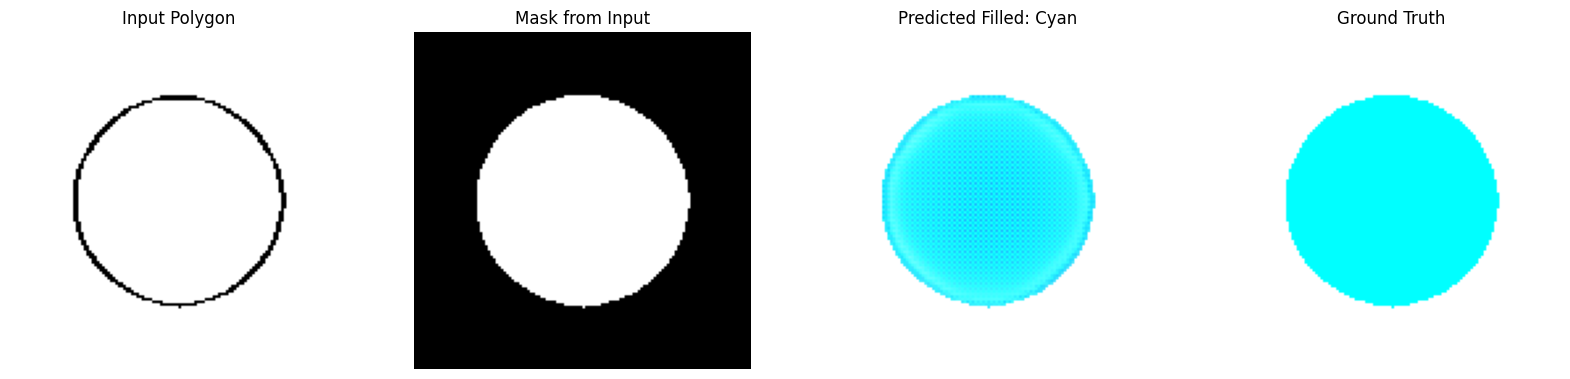

In [50]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# Color map
color_map = {
    'cyan': (0, 255, 255),
    'purple': (128, 0, 128),
    'magenta': (255, 0, 255),
    'green': (0, 255, 0),
    'red': (255, 0, 0),
    'yellow': (255, 255, 0),
    'blue': (0, 0, 255),
    'orange': (255, 165, 0)
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

# Upload input image
from google.colab import files
uploaded = files.upload()  # Prompt: upload a polygon outline image (.png or .jpg)
custom_img_path = list(uploaded.keys())[0]
img_pil = Image.open(custom_img_path).convert('L').resize((128, 128))
img_np = np.array(img_pil)

# Optional: Upload ground truth image
print("Upload ground truth image (optional, pre-colored polygon, .png or .jpg) or press Enter to skip.")
gt_uploaded = files.upload()
gt_img_path = list(gt_uploaded.keys())[0] if gt_uploaded else None
if gt_img_path:
    gt_img_pil = Image.open(gt_img_path).resize((128, 128))
    gt_img_np = np.array(gt_img_pil) / 255.0  # Normalize to [0, 1]
else:
    gt_img_np = None

# Choose color
print('Available colors:', list(color_map.keys()))
color_name = input('Enter desired color: ').strip().lower()
if color_name not in color_map:
    raise ValueError(f"Invalid color! Must be one of {list(color_map.keys())}")
color_rgb = torch.tensor(color_map[color_name], dtype=torch.float32).unsqueeze(0).to(device) / 255.0

# Create filled mask from uploaded image
_, mask_bin = cv2.threshold(255 - img_np, 10, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_filled = np.zeros_like(mask_bin)
cv2.drawContours(mask_filled, contours, -1, color=255, thickness=cv2.FILLED)
mask_filled = mask_filled.astype(np.float32) / 255.0
mask_filled = np.expand_dims(mask_filled, axis=0)

# Model inference
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
with torch.no_grad():
    img_tensor = transform(img_pil).unsqueeze(0).to(device)
    output_img = model(img_tensor, color_rgb)
output_img = torch.clamp(output_img, 0, 1).squeeze().cpu().numpy()

# Compose final image
output_final = output_img * mask_filled + (1 - mask_filled) * 1.0

# Visualize
if gt_img_np is not None:
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1); plt.title('Input Polygon'); plt.imshow(img_np, cmap='gray'); plt.axis('off')
    plt.subplot(1, 4, 2); plt.title('Mask from Input'); plt.imshow(mask_filled[0], cmap='gray'); plt.axis('off')
    plt.subplot(1, 4, 3); plt.title(f'Predicted Filled: {color_name.title()}'); plt.imshow(np.transpose(output_final, (1, 2, 0))); plt.axis('off')
    plt.subplot(1, 4, 4); plt.title('Ground Truth'); plt.imshow(gt_img_np); plt.axis('off')
else:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1); plt.title('Input Polygon'); plt.imshow(img_np, cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title('Mask from Input'); plt.imshow(mask_filled[0], cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title(f'Filled: {color_name.title()}'); plt.imshow(np.transpose(output_final, (1, 2, 0))); plt.axis('off')
plt.show()

Saving hexagon.png to hexagon (1).png
Upload ground truth image (optional, pre-colored polygon, .png or .jpg) or press Enter to skip.


Saving green_hexagon.png to green_hexagon.png
Available colors: ['cyan', 'purple', 'magenta', 'green', 'red', 'yellow', 'blue', 'orange']
Enter desired color: green


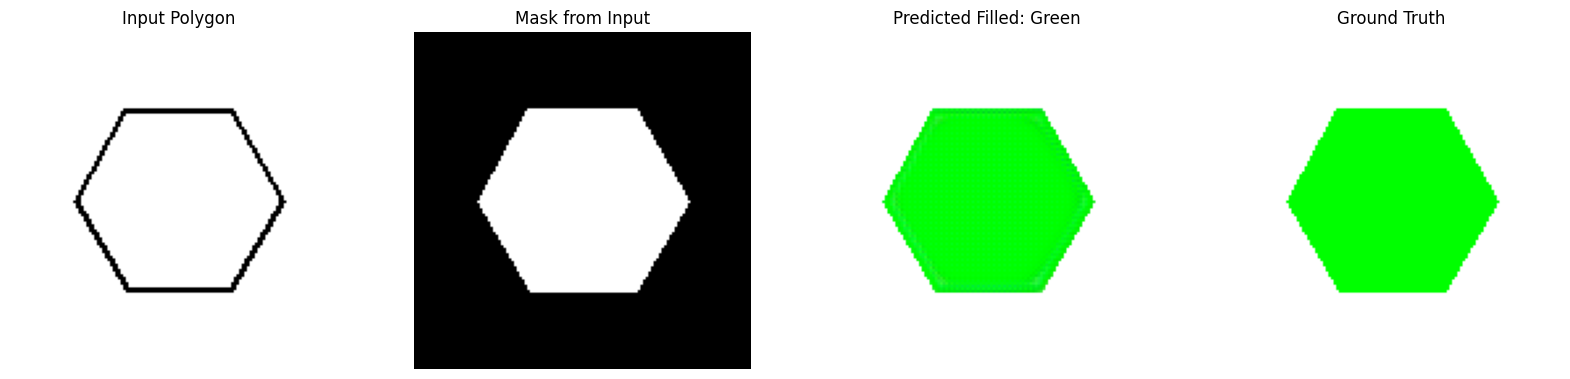

In [52]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# Color map
color_map = {
    'cyan': (0, 255, 255),
    'purple': (128, 0, 128),
    'magenta': (255, 0, 255),
    'green': (0, 255, 0),
    'red': (255, 0, 0),
    'yellow': (255, 255, 0),
    'blue': (0, 0, 255),
    'orange': (255, 165, 0)
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

# Upload input image
from google.colab import files
uploaded = files.upload()  # Prompt: upload a polygon outline image (.png or .jpg)
custom_img_path = list(uploaded.keys())[0]
img_pil = Image.open(custom_img_path).convert('L').resize((128, 128))
img_np = np.array(img_pil)

# Optional: Upload ground truth image
print("Upload ground truth image (optional, pre-colored polygon, .png or .jpg) or press Enter to skip.")
gt_uploaded = files.upload()
gt_img_path = list(gt_uploaded.keys())[0] if gt_uploaded else None
if gt_img_path:
    gt_img_pil = Image.open(gt_img_path).resize((128, 128))
    gt_img_np = np.array(gt_img_pil) / 255.0  # Normalize to [0, 1]
else:
    gt_img_np = None

# Choose color
print('Available colors:', list(color_map.keys()))
color_name = input('Enter desired color: ').strip().lower()
if color_name not in color_map:
    raise ValueError(f"Invalid color! Must be one of {list(color_map.keys())}")
color_rgb = torch.tensor(color_map[color_name], dtype=torch.float32).unsqueeze(0).to(device) / 255.0

# Create filled mask from uploaded image
_, mask_bin = cv2.threshold(255 - img_np, 10, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask_filled = np.zeros_like(mask_bin)
cv2.drawContours(mask_filled, contours, -1, color=255, thickness=cv2.FILLED)
mask_filled = mask_filled.astype(np.float32) / 255.0
mask_filled = np.expand_dims(mask_filled, axis=0)

# Model inference
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
with torch.no_grad():
    img_tensor = transform(img_pil).unsqueeze(0).to(device)
    output_img = model(img_tensor, color_rgb)
output_img = torch.clamp(output_img, 0, 1).squeeze().cpu().numpy()

# Compose final image
output_final = output_img * mask_filled + (1 - mask_filled) * 1.0

# Visualize
if gt_img_np is not None:
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1); plt.title('Input Polygon'); plt.imshow(img_np, cmap='gray'); plt.axis('off')
    plt.subplot(1, 4, 2); plt.title('Mask from Input'); plt.imshow(mask_filled[0], cmap='gray'); plt.axis('off')
    plt.subplot(1, 4, 3); plt.title(f'Predicted Filled: {color_name.title()}'); plt.imshow(np.transpose(output_final, (1, 2, 0))); plt.axis('off')
    plt.subplot(1, 4, 4); plt.title('Ground Truth'); plt.imshow(gt_img_np); plt.axis('off')
else:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1); plt.title('Input Polygon'); plt.imshow(img_np, cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title('Mask from Input'); plt.imshow(mask_filled[0], cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title(f'Filled: {color_name.title()}'); plt.imshow(np.transpose(output_final, (1, 2, 0))); plt.axis('off')
plt.show()

In [53]:
import gdown

# Download model from Google Drive
url = 'https://drive.google.com/file/d/1pjKT-Zxa-9kTlmKN5d0DjdLMvOcX72NM/view?usp=sharing'  # Replace with your link
output = 'unet_model.pth'
gdown.download(url, output, quiet=False)

/usr/local/lib/python3.11/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1pjKT-Zxa-9kTlmKN5d0DjdLMvOcX72NM
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1pjKT-Zxa-9kTlmKN5d0DjdLMvOcX72NM/view?usp=sharing
To: /content/unet_model.pth
102kB [00:00, 12.0MB/s]


'unet_model.pth'

In [51]:
import torch

def pixel_accuracy(pred, target, threshold=0.5):
    # pred, target: torch tensors shape (3, H, W), color outputs normalized [0,1]
    # Convert to binary masks by thresholding pixel intensity average across channels
    pred_mask = (pred.mean(dim=0) > threshold).float()
    target_mask = (target.mean(dim=0) > threshold).float()

    correct = (pred_mask == target_mask).float().sum()
    total = torch.numel(pred_mask)
    return (correct / total).item()

def iou_score(pred, target, threshold=0.5):
    pred_mask = (pred.mean(dim=0) > threshold).float()
    target_mask = (target.mean(dim=0) > threshold).float()

    intersection = (pred_mask * target_mask).sum()
    union = pred_mask.sum() + target_mask.sum() - intersection
    if union == 0:
        return 1.0  # If both empty, perfect overlap
    return (intersection / union).item()

# Example evaluation on validation set
model.eval()
pixel_acc_list = []
iou_list = []

for input_img, color_rgb, target_img in val_loader:
    input_img = input_img.to(device)
    color_rgb = color_rgb.to(device)
    target_img = target_img.to(device)

    with torch.no_grad():
        output_img = model(input_img, color_rgb)
        output_img = torch.clamp(output_img, 0, 1)

    # Calculate metrics batch-wise
    for i in range(input_img.size(0)):
        pa = pixel_accuracy(output_img[i], target_img[i])
        iou = iou_score(output_img[i], target_img[i])
        pixel_acc_list.append(pa)
        iou_list.append(iou)

print(f'Validation Pixel Accuracy: {sum(pixel_acc_list)/len(pixel_acc_list):.4f}')
print(f'Validation IoU Score: {sum(iou_list)/len(iou_list):.4f}')


Validation Pixel Accuracy: 0.9843
Validation IoU Score: 0.9809
